Drugie podejście do modelu

In [37]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from os.path import join as JoinPath
from cmdstanpy import CmdStanModel
from scipy.stats import gaussian_kde

In [38]:
# Pozyskiwanie zależności
eh = pd.read_csv('electricity_household' + '.tsv', sep='\t',header=0, index_col='country')
eh_mean_list = list(eh.mean())

ei = pd.read_csv('electricity_industry' + '.tsv', sep='\t',header=0, index_col='country')
ei_mean_list = list(ei.mean())

gh = pd.read_csv('gas_household' + '.tsv', sep='\t',header=0, index_col='country')
gh = gh.drop(['1990-S2 '], axis=1) # Usunięcie wymagane poniewać eurostat wykonał tutaj jeden dodatkowy punkt pomiarowy
gh_mean_list = list(gh.mean())

gi = pd.read_csv('gas_industry' + '.tsv', sep='\t',header=0, index_col='country')
gi_mean_list = list(gi.mean())

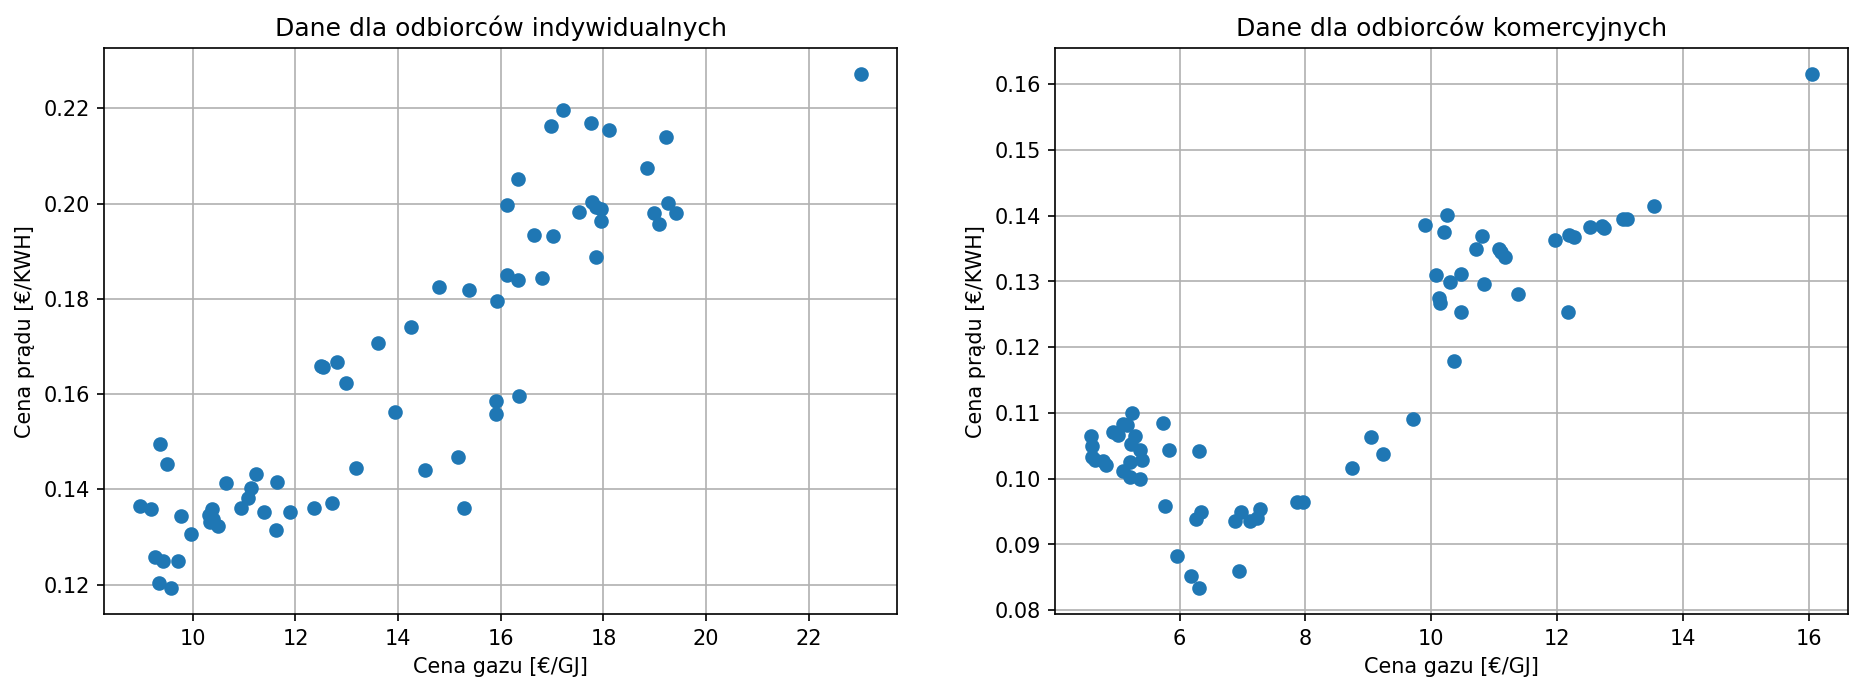

In [39]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5), dpi=150)
plt.rcParams['axes.grid'] = True

ax1.plot(gh_mean_list, eh_mean_list, 'o')
ax1.set_title("Dane dla odbiorców indywidualnych")
ax1.set_xlabel("Cena gazu [€/GJ]")
ax1.set_ylabel("Cena prądu [€/KWH]")

ax2.plot(gi_mean_list, ei_mean_list, 'o')
ax2.set_title("Dane dla odbiorców komercyjnych")
ax2.set_xlabel("Cena gazu [€/GJ]")
ax2.set_ylabel("Cena prądu [€/KWH]")

plt.show()

# Obliczenia przy użyciu STAN

In [40]:
# Numer modelu oznacza stopień wielomianu dopasowania
model_1_fit=CmdStanModel(stan_file=JoinPath('stan-files', 'model_1.stan'))
model_2_fit=CmdStanModel(stan_file=JoinPath('stan-files', 'model_2.stan'))
model_3_fit=CmdStanModel(stan_file=JoinPath('stan-files', 'model_3.stan'))
model_4_fit=CmdStanModel(stan_file=JoinPath('stan-files', 'model_4.stan'))

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiling stan file E:\Obiekty 3D\GitHub\Projekt-DataAnalytics-2022\Source_Code\stan-files\model_2.stan to exe file E:\Obiekty 3D\GitHub\Projekt-DataAnalytics-2022\Source_Code\stan-files\model_2.exe
INFO:cmdstanpy:compiled model executable: E:\Obiekty 3D\GitHub\Projekt-DataAnalytics-2022\Source_Code\stan-files\model_2.exe
INFO:cmdstanpy:compiling stan file E:\Obiekty 3D\GitHub\Projekt-DataAnalytics-2022\Source_Code\stan-files\model_3.stan to exe file E:\Obiekty 3D\GitHub\Projekt-DataAnalytics-2022\Source_Code\stan-files\model_3.exe
INFO:cmdstanpy:compiled model executable: E:\Obiekty 3D\GitHub\Projekt-DataAnalytics-2022\Source_Code\stan-files\model_3.exe
INFO:cmdstanpy:compiling stan file E:\Obiekty 3D\GitHub\Projekt-DataAnalytics-2022\Source_Code\stan-files\model_4.stan to exe file E:\Obiekty 3D\GitHub\Projekt-DataAnalytics-2022\Source_Code\stan-files\model_4.exe
INFO:cmdstanpy:compiled model executable: E:\Obiekty 3D

In [41]:
def fit(model, x, y):
    data = {}
    data['N'] = len(x)
    data['x'] = x
    data['y'] = y
    return model.sample(data=data, seed=2137)

In [42]:
h_fit_degree1 = fit(model_1_fit, gh_mean_list, eh_mean_list)
h_fit_degree2 = fit(model_2_fit, gh_mean_list, eh_mean_list)
h_fit_degree3 = fit(model_3_fit, gh_mean_list, eh_mean_list)
h_fit_degree4 = fit(model_4_fit, gh_mean_list, eh_mean_list)

i_fit_degree1 = fit(model_1_fit, gi_mean_list, ei_mean_list)
i_fit_degree2 = fit(model_2_fit, gi_mean_list, ei_mean_list)
i_fit_degree3 = fit(model_3_fit, gi_mean_list, ei_mean_list)
i_fit_degree4 = fit(model_4_fit, gi_mean_list, ei_mean_list)

INFO:cmdstanpy:CmdStan start procesing
chain 1 |          | 00:00 Status



chain 1 |█████▉    | 00:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start procesing
chain 1 |          | 00:00 Status



chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)

chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)



chain 1 |████▌     | 00:00 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████▉    | 00:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)



chain 1 |███████▋  | 00:01 Iteration: 1400 / 2000 [ 70%]  (Sampling)

chain 1 |████████▋ | 00:01 Iteration: 1600 / 2000 [ 80%]  (Sampling)

chain 1 |██████████| 00:01 Sampling completed                       
chain 2 |██████████| 00:01 Sampling completed                       
chain 3 |██████████| 00:01 Sampling completed                       
chain 4 |██████████| 00:01 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start procesing
chain 1 |          | 00:00 Status





chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)




chain 1 |████▌     | 00:00 Iteration:  800 / 2000 [ 40%]  (Warmup)
chain 1 |█████▉    | 00:01 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▊   | 00:01 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |███████▋  | 00:01 Iteration: 1400 / 2000 [ 70%]  (Sampling)


chain 1 |████████▋ | 00:01 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:02 Sampling completed                       
chain 2 |██████████| 00:02 Sampling completed                       
chain 3 |██████████| 00:02 Sampling completed                       
chain 4 |██████████| 00:02 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start procesing
chain 1 |          | 00:00 Status





chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)
chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)

chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)
chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:01 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▊   | 00:01 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |███████▋  | 00:01 Iteration: 1400 / 2000 [ 70%]  (Sampling)


chain 1 |████████▏ | 00:01 Iteration: 1500 / 2000 [ 75%]  (Sampling)
chain 1 |████████▋ | 00:01 Iteration: 1600 / 2000 [ 80%]  (Sampling)

chain 1 |█████████ | 00:02 Iteration: 1700 / 2000 [ 85%]  (Sampling)

chain 1 |██████████| 0


INFO:cmdstanpy:CmdStan done processing.
INFO:cmdstanpy:CmdStan start procesing


chain 1 |          | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.
INFO:cmdstanpy:CmdStan start procesing


chain 1 |          | 00:00 Status



chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)




chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |██████▎   | 00:00 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.
INFO:cmdstanpy:CmdStan start procesing


chain 1 |          | 00:00 Status





chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)
chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |████▌     | 00:00 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████▉    | 00:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)
chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)





chain 1 |██████████| 00:01 Iteration: 1900 / 2000 [ 95%]  (Sampling)


chain 1 |██████████| 00:01 Sampling completed                       
chain 2 |██████████| 00:01 Sampling completed                       
chain 3 |██████████| 00:01 Sampling completed                       
chain 4 |██████████| 00:01 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.
INFO:cmdstanpy:CmdStan start procesing


chain 1 |          | 00:00 Status





chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████▌     | 00:00 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████▉    | 00:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▊   | 00:01 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |███████▋  | 00:01 Iteration: 1400 / 2000 [ 70%]  (Sampling)



chain 1 |████████▋ | 00:01 Iteration: 1600 / 2000 [ 80%]  (Sampling)

chain 1 |██████████| 00:01 Sampling completed                       
chain 2 |██████████| 00:01 Sampling completed                       
chain 3 |██████████| 00:01 Sampling completed                       
chain 4 |██████████| 00:01 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


# Wyświetlanie danych wynikowych dopasowania

In [82]:
def PlotFitedData(x, y, fit_data, fit_degree, ax):
    alpha = np.mean(fit_data.stan_variable("alpha"))
    beta = np.mean(fit_data.stan_variable("beta"))
    gamma = None
    if fit_degree > 1:
        gamma = np.mean(fit_data.stan_variable("gamma"))
    delta = None
    if fit_degree > 2:
        delta = np.mean(fit_data.stan_variable("delta"))
    epsilon = None
    if fit_degree > 3:
        epsilon = np.mean(fit_data.stan_variable("epsilon"))
    sigma = np.mean(fit_data.stan_variable("sigma"))
    y_sim_to_mean = fit_data.stan_variable("y_sim")

    y_sim = []
    for i in range(len(x)):
        y_sim.append(y_sim_to_mean[2,i])

    dev = []
    if fit_degree == 1:
        dev = [alpha + beta*x_ for x_ in x]
    elif fit_degree == 2:
        dev = [alpha + beta*x_ + gamma*pow(x_,2) for x_ in x]
    elif fit_degree == 3:
        dev = [alpha + beta*x_ + gamma*pow(x_,2) + delta*pow(x_,3) for x_ in x]
    elif fit_degree == 4:
        dev = [alpha + beta*x_ + gamma*pow(x_,2) + delta*pow(x_,3) + epsilon*pow(x_,4) for x_ in x]
    else:
        print('Brak implementacji plotowania rzędu dopasowania')
        return None
    
    print(f'Dopasowanie wielomianem rzędu = {fit_degree}, alpha = {alpha}, beta = {beta}, gamma = {gamma}, delta = {delta}, epsilon = {epsilon}')
    
    upper_dev = [dev_ + sigma for dev_ in dev]
    lower_dev = [dev_ - sigma for dev_ in dev]

    ax.plot(x, y, 'ro', label='Orginalne dane')
    ax.plot(x, y_sim, 'bo', label='Wygenerowane dane')
    ax.plot(sorted(x), sorted(dev), 'tab:purple', label='Maksimum rozkładu normalnego')
    ax.plot(sorted(x), sorted(upper_dev), 'tab:orange', label='Dolne odchylenie rozkładu normalnego')
    ax.plot(sorted(x), sorted(lower_dev), 'tab:green', label='Górne odchylenie rozkładu normalnego')
    ax.set_xlabel("Cena gazu [€/GJ]")
    ax.set_ylabel("Cena prądu [€/KWH]")

    if fit_degree == 1:
        ax.set_title('Model α + βx\nα={:.5f},β={:.5f}; σ={:.5f}'.format(alpha, beta, sigma))
    elif fit_degree == 2:
        ax.set_title('Model α + βx + γx^2\nα={:.5f},β={:.5f},γ={:.5f}; σ={:.5f}'.format(alpha, beta, gamma, sigma))
    elif fit_degree == 3:
        ax.set_title('Model α + βx + γx^2 + δx^3\nα={:.5f},β={:.5f},γ={:.5f},δ={:.5f}; σ={:.5f}'.format(alpha, beta, gamma, delta, sigma))
    elif fit_degree == 4:
        ax.set_title('Model α + βx + γx^2 + δx^3 + εx^4\nα={:.5f},β={:.5f},γ={:.5f},δ={:.5f},ε={:.5f}; σ={:.5f}'.format(alpha, beta, gamma, delta, epsilon, sigma))
    return (alpha, beta, gamma, delta, epsilon, sigma)


def PlotProbabilityDensity(y, fit_data, fit_degree, ax, densityNum=15, linStart=0, linEnd=1, linNum=500):
    u = np.linspace(linStart, linEnd, linNum)
    y_sim = fit_data.stan_variable('y_sim')
    all_sim_density = []
    for i in range(densityNum):
        kernel = gaussian_kde(sorted(y_sim[i, :]))
        evaluation = kernel.evaluate(u)
        all_sim_density.append(evaluation)
        if i == densityNum-1:
            ax.plot(u, evaluation, 'g', linewidth=0.5, label='Simulated probability density - first {0}'.format(densityNum))
        elif i < densityNum:
            ax.plot(u, evaluation, 'g', linewidth=0.5)
    tmp_all_sim_density_array = [np.array(x) for x in all_sim_density]
    mean_sim_density = [np.mean(k) for k in zip(*tmp_all_sim_density_array)]
    ax.plot(u, mean_sim_density, 'b', linewidth=1.5, label='Probability density')
    kernel = gaussian_kde(sorted(y))
    input_density = kernel.evaluate(u)
    ax.plot(u, input_density, 'r', linewidth=1.5, label='Probability density')

    if fit_degree == 1:
        ax.set_title('Model α + βx')
    elif fit_degree == 2:
        ax.set_title('Model α + βx + γx^2')
    elif fit_degree == 3:
        ax.set_title('Model α + βx + γx^2 + δx^3')
    elif fit_degree == 4:
        ax.set_title('Model α + βx + γx^2 + δx^3 + εx^4')
    return (input_density, mean_sim_density, u)

def PlotDensityDifference(original, simulated, u, fit_degree, ax) :
    '''
        Funkcja plotuje original - simulated
    '''
    density_difference = original - simulated
    ax.plot(u, density_difference, 'r', linewidth=1.5, label='Probability density difference')

    if fit_degree == 1:
        ax.set_title('Model α + βx')
    elif fit_degree == 2:
        ax.set_title('Model α + βx + γx^2')
    elif fit_degree == 3:
        ax.set_title('Model α + βx + γx^2 + δx^3')
    elif fit_degree == 4:
        ax.set_title('Model α + βx + γx^2 + δx^3 + εx^4')
    print('Total difference:', np.sum(np.abs(density_difference)))
    return density_difference


Dopasowanie wielomianem rzędu = 1, alpha = 0.05172226747499999, beta = 0.0080438771525, gamma = None, delta = None, epsilon = None
Dopasowanie wielomianem rzędu = 2, alpha = 0.0744602317, beta = 0.004660815703500001, gamma = 0.00011834113652375, delta = None, epsilon = None
Dopasowanie wielomianem rzędu = 3, alpha = 0.0800546377, beta = 0.004249666350174999, gamma = 8.713580855427499e-05, delta = 2.0393261086965e-06, epsilon = None
Dopasowanie wielomianem rzędu = 4, alpha = 0.08321071477500001, beta = 0.00406172242625, gamma = 7.561649316124749e-05, delta = 1.7719409673201499e-06, epsilon = 5.12730011519e-08


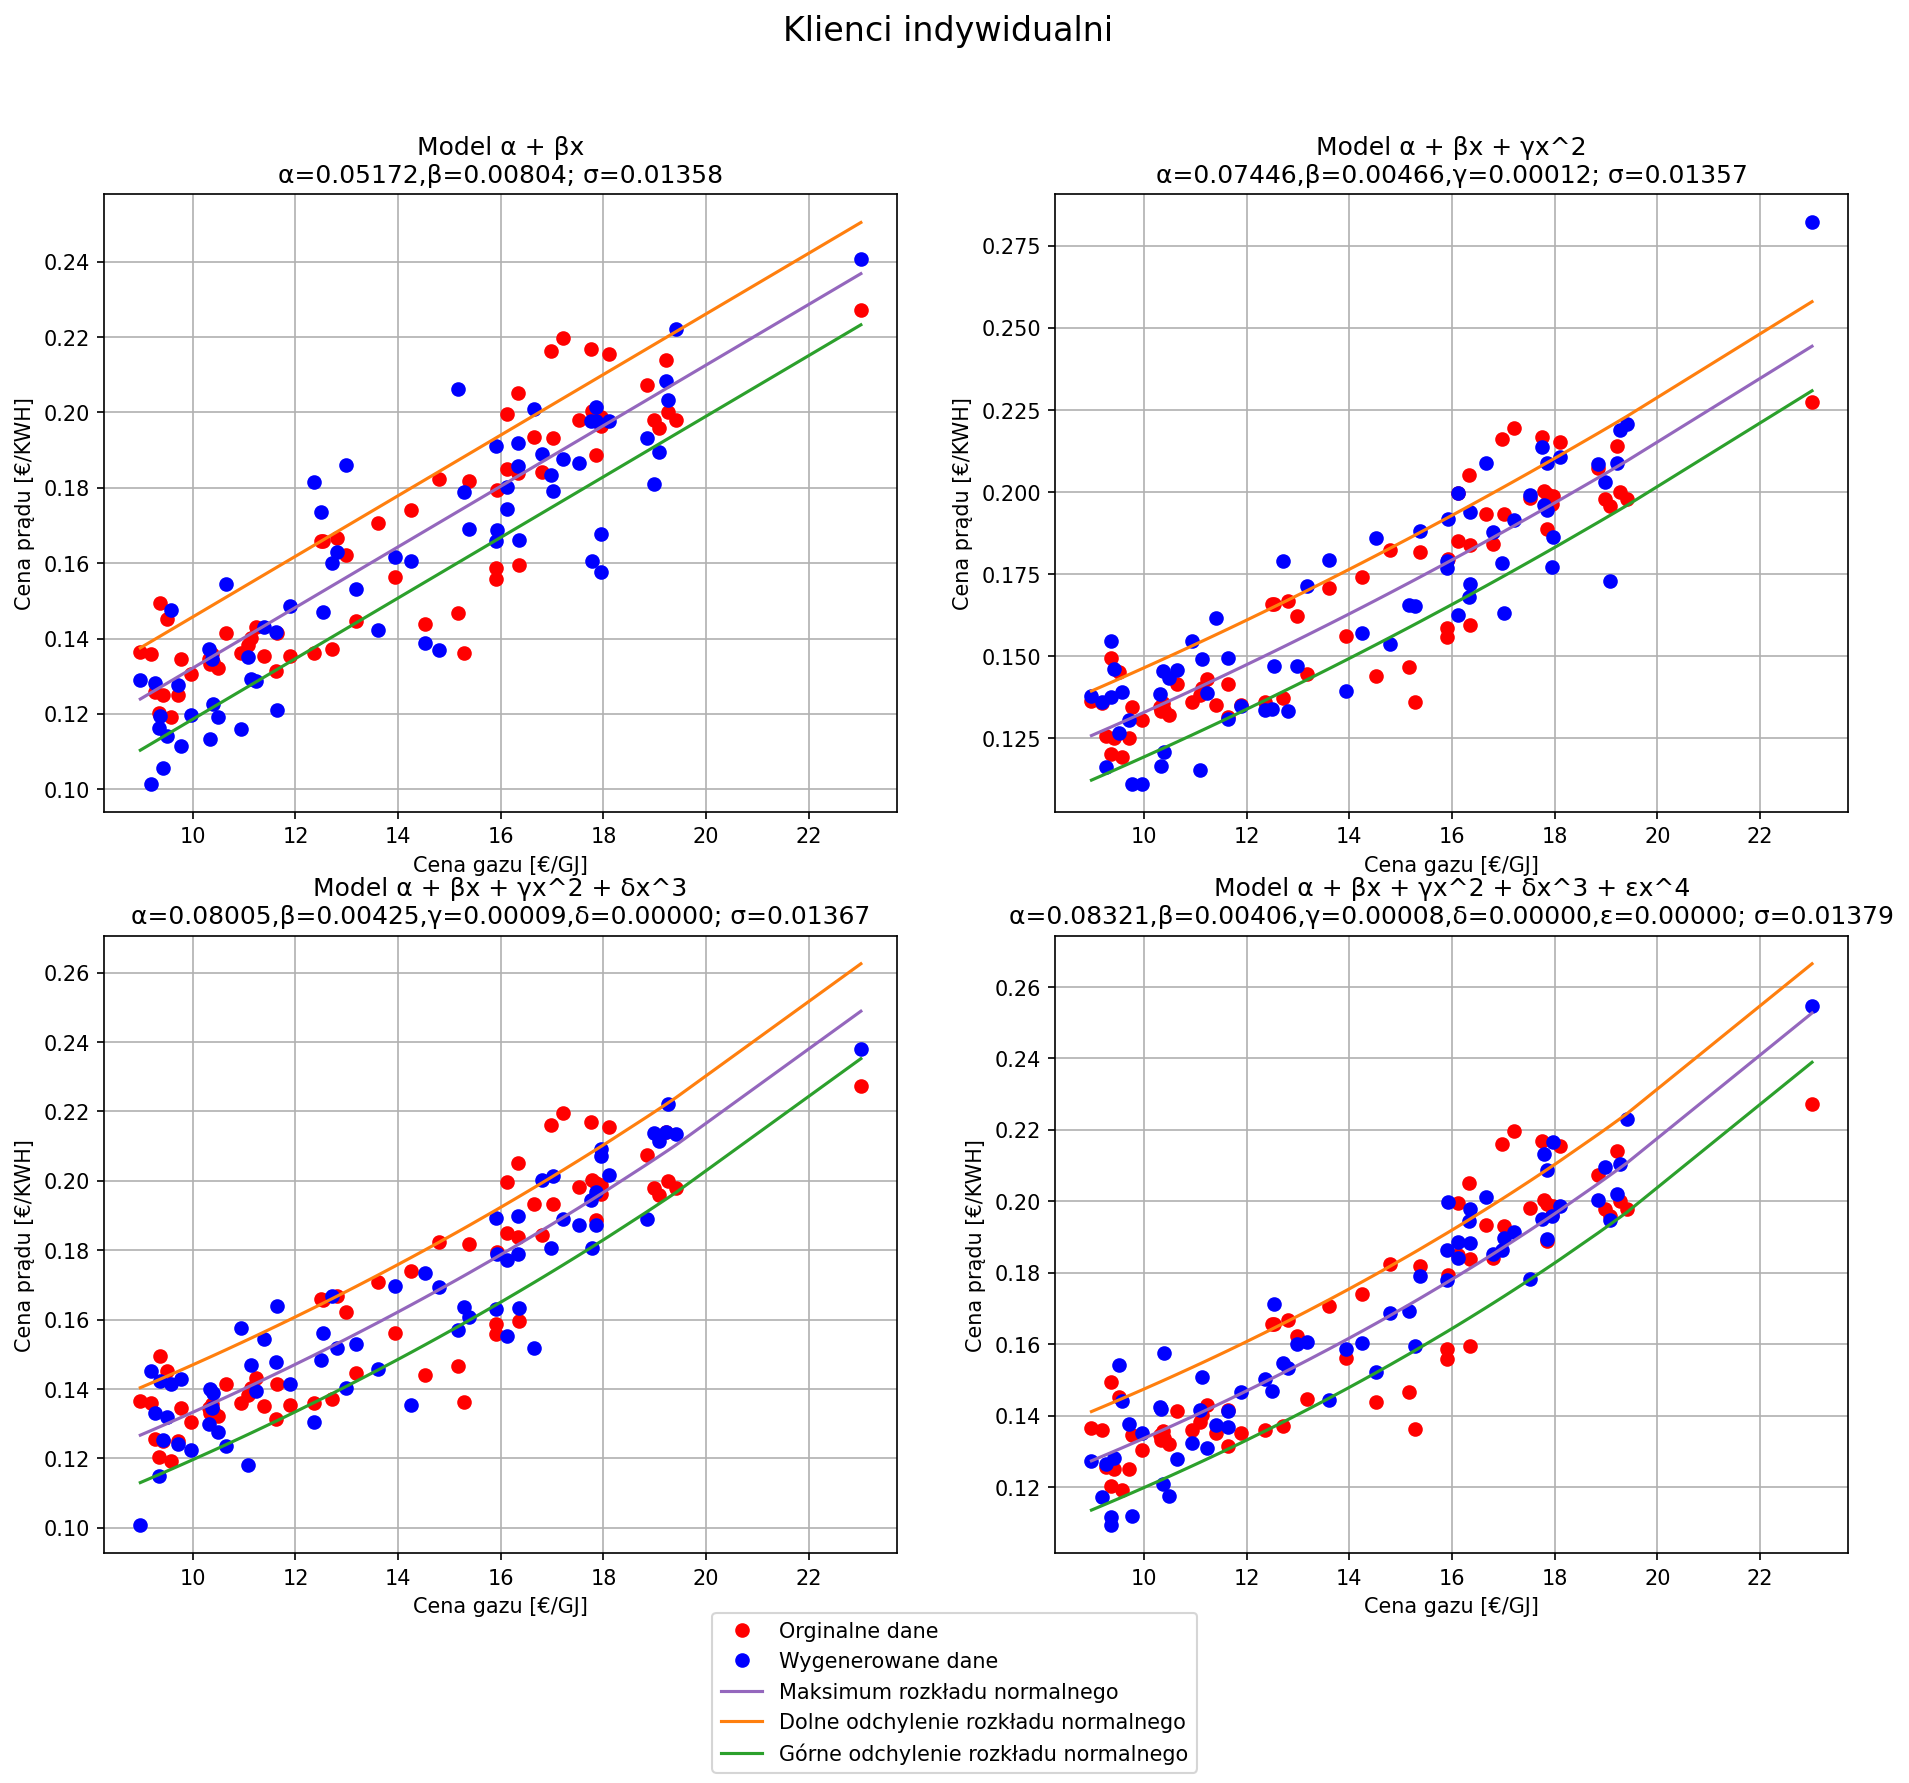

In [44]:
f, axs = plt.subplots(2, 2, figsize=(15,12), dpi=150)

PlotFitedData(gh_mean_list, eh_mean_list, h_fit_degree1, 1, axs[0, 0])
PlotFitedData(gh_mean_list, eh_mean_list, h_fit_degree2, 2, axs[0, 1])
PlotFitedData(gh_mean_list, eh_mean_list, h_fit_degree3, 3, axs[1, 0])
PlotFitedData(gh_mean_list, eh_mean_list, h_fit_degree4, 4, axs[1, 1])

f.suptitle('Klienci indywidualni', fontsize=16)
plt.rcParams['axes.grid'] = True
handles, labels = axs[0, 0].get_legend_handles_labels()
f.legend(handles, labels, loc='lower center')
plt.savefig('Dopasowanie klienci indywidualni.png', dpi=300, facecolor='w')
plt.show()

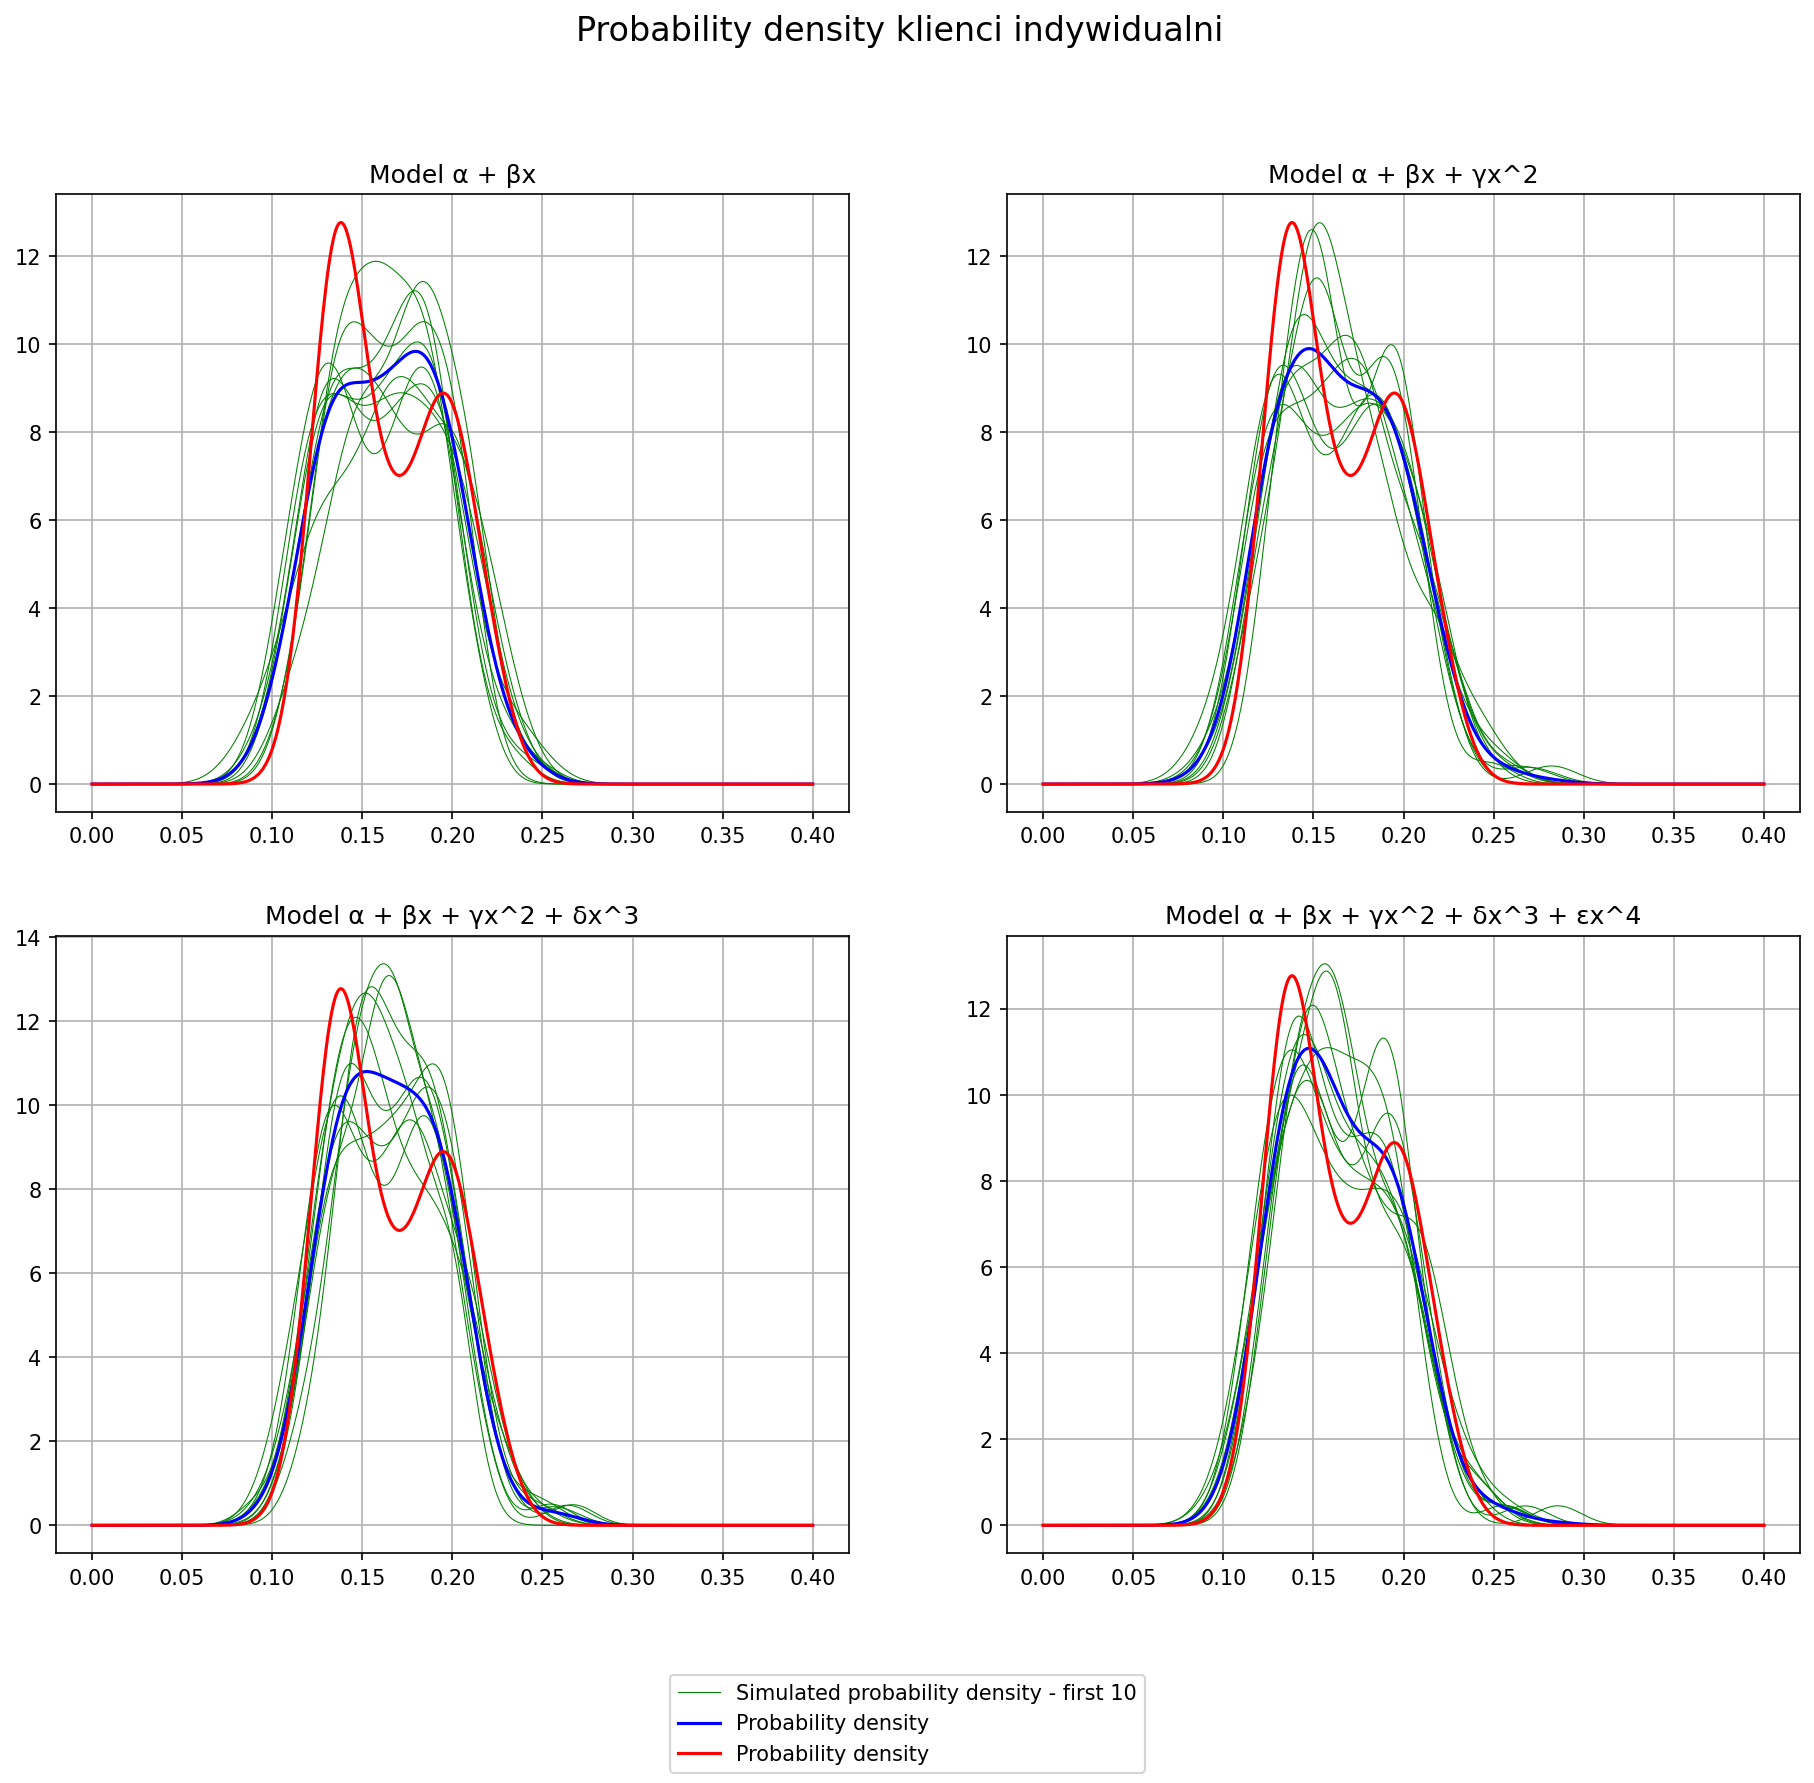

In [89]:
f, axs = plt.subplots(2, 2, figsize=(15,12), dpi=150)

(h_density1, h_sim_density1, uh1) = PlotProbabilityDensity(eh_mean_list, h_fit_degree1, 1, axs[0, 0], densityNum=10, linEnd=0.4)
(h_density2, h_sim_density2, uh2) = PlotProbabilityDensity(eh_mean_list, h_fit_degree2, 2, axs[0, 1], densityNum=10, linEnd=0.4)
(h_density3, h_sim_density3, uh3) = PlotProbabilityDensity(eh_mean_list, h_fit_degree3, 3, axs[1, 0], densityNum=10, linEnd=0.4)
(h_density4, h_sim_density4, uh4) = PlotProbabilityDensity(eh_mean_list, h_fit_degree4, 4, axs[1, 1], densityNum=10, linEnd=0.4)

f.suptitle('Probability density klienci indywidualni', fontsize=16)
plt.rcParams['axes.grid'] = True
handles, labels = axs[0, 0].get_legend_handles_labels()
f.legend(handles, labels, loc='lower center')
plt.savefig('Probability density klienci indywidualni.png', dpi=300, facecolor='w')
plt.show()

Total difference: 290.9177144135513
Total difference: 253.52038222731795
Total difference: 293.85320871439944
Total difference: 233.1390525160547


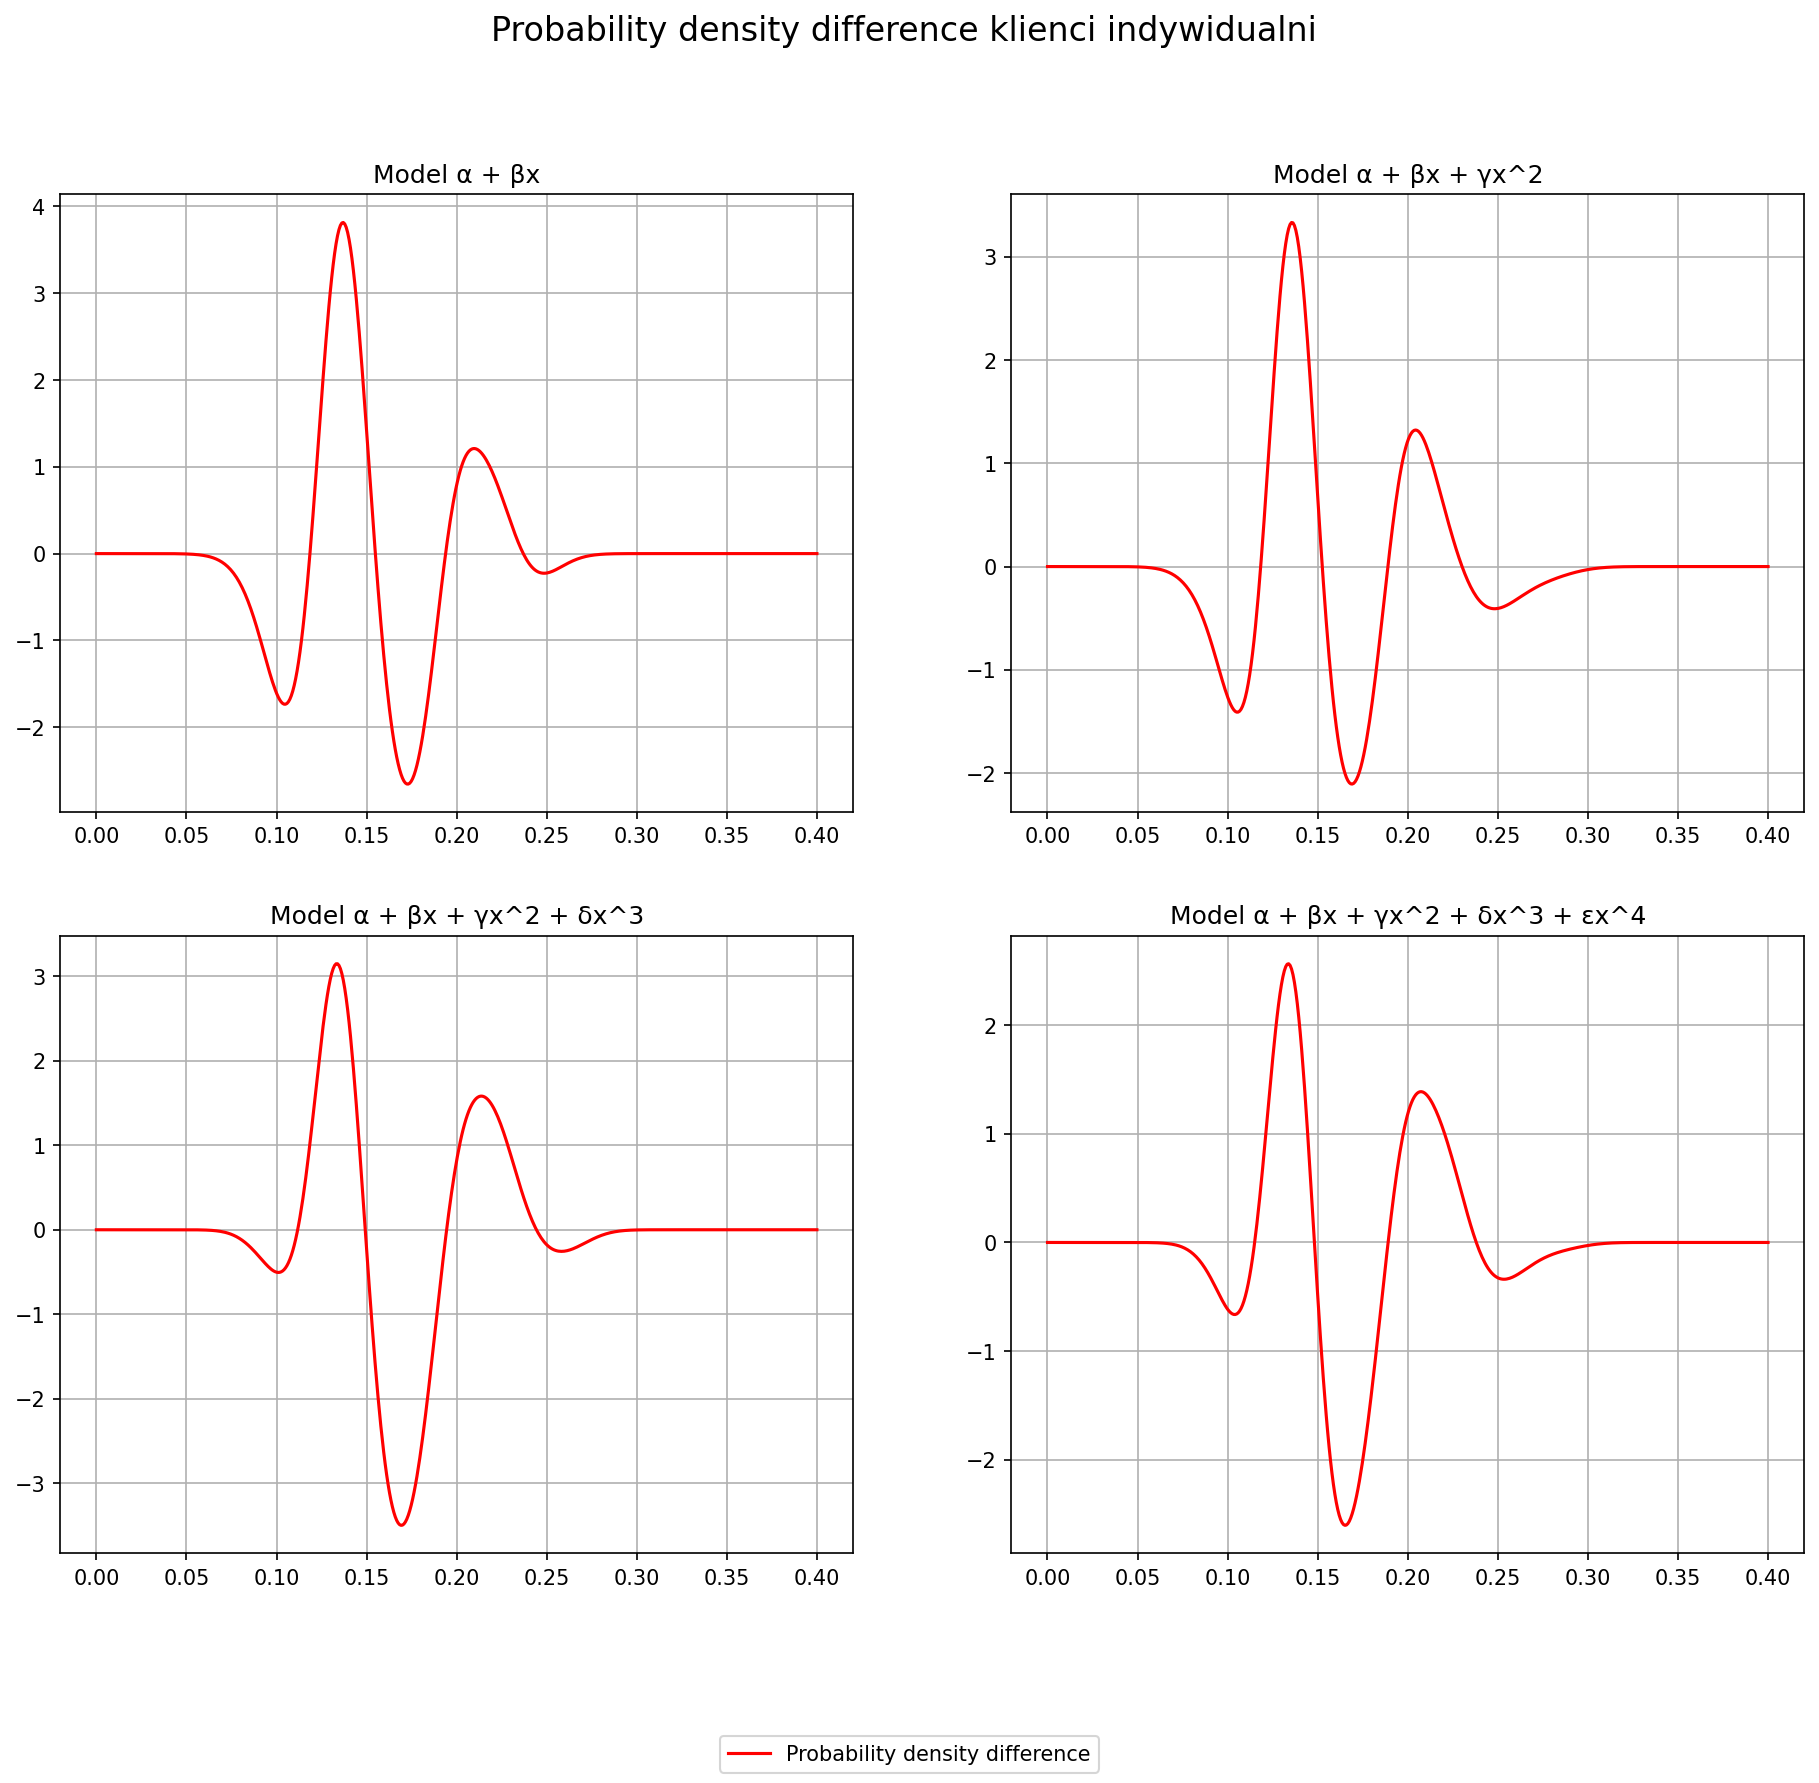

In [88]:
f, axs = plt.subplots(2, 2, figsize=(15,12), dpi=150)

PlotDensityDifference(h_density1, h_sim_density1, uh1, 1, axs[0, 0])
PlotDensityDifference(h_density2, h_sim_density2, uh2, 2, axs[0, 1])
PlotDensityDifference(h_density3, h_sim_density3, uh3, 3, axs[1, 0])
PlotDensityDifference(h_density4, h_sim_density4, uh4, 4, axs[1, 1])

f.suptitle('Probability density difference klienci indywidualni', fontsize=16)
plt.rcParams['axes.grid'] = True
handles, labels = axs[0, 0].get_legend_handles_labels()
f.legend(handles, labels, loc='lower center')
plt.savefig('Probability density difference klienci indywidualni.png', dpi=300, facecolor='w')
plt.show()

Dopasowanie wielomianem rzędu = 1, alpha = 0.070612373375, beta = 0.005256523282500001, gamma = None, delta = None, epsilon = None
Dopasowanie wielomianem rzędu = 2, alpha = 0.08559552715, beta = 0.0014713698672175, gamma = 0.000212714344275, delta = None, epsilon = None
Dopasowanie wielomianem rzędu = 3, alpha = 0.08811872035000001, beta = 0.0012956335672275, gamma = 0.00012543671135425, delta = 7.0634547945775e-06, epsilon = None
Dopasowanie wielomianem rzędu = 4, alpha = 0.08849043075, beta = 0.0013734876060674998, gamma = 0.000108631215054075, delta = 5.1242871224475e-06, epsilon = 2.07216953686e-07


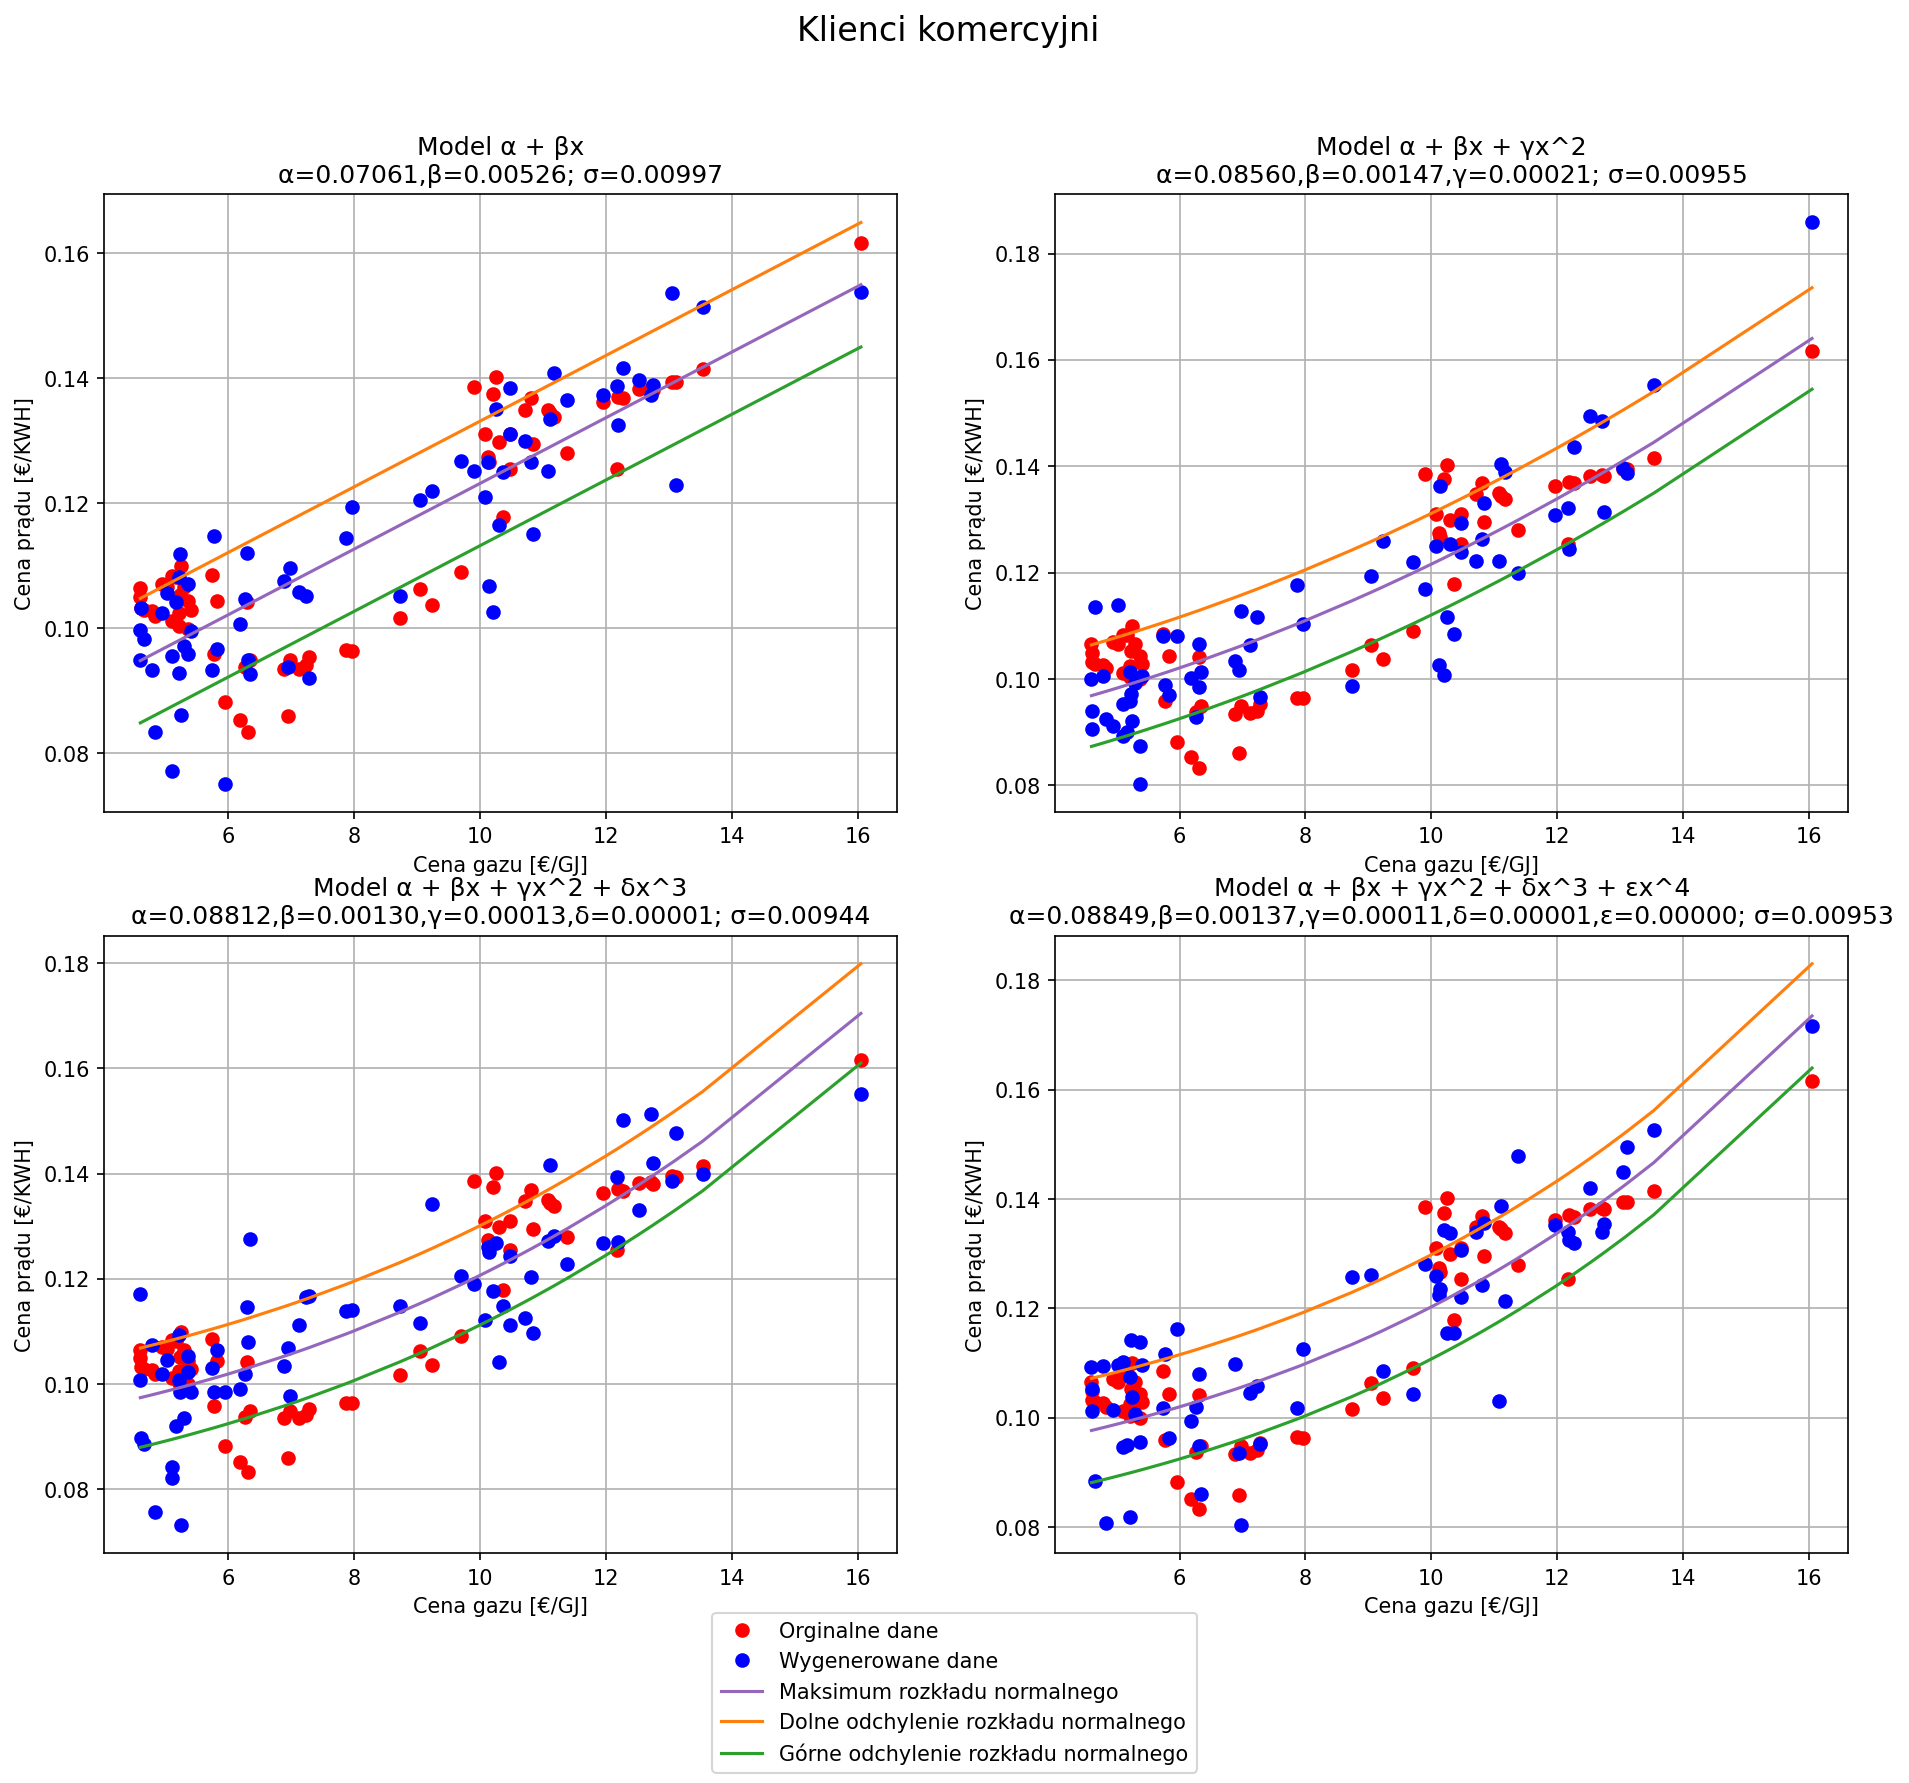

In [70]:
f, axs = plt.subplots(2, 2, figsize=(15,12), dpi=150)

PlotFitedData(gi_mean_list, ei_mean_list, i_fit_degree1, 1, axs[0, 0])
PlotFitedData(gi_mean_list, ei_mean_list, i_fit_degree2, 2, axs[0, 1])
PlotFitedData(gi_mean_list, ei_mean_list, i_fit_degree3, 3, axs[1, 0])
PlotFitedData(gi_mean_list, ei_mean_list, i_fit_degree4, 4, axs[1, 1])

f.suptitle('Klienci komercyjni', fontsize=16)
plt.rcParams['axes.grid'] = True
handles, labels = axs[0, 0].get_legend_handles_labels()
f.legend(handles, labels, loc='lower center')
plt.savefig('Dopasowanie klienci komercyjni.png', dpi=300, facecolor='w')
plt.show()

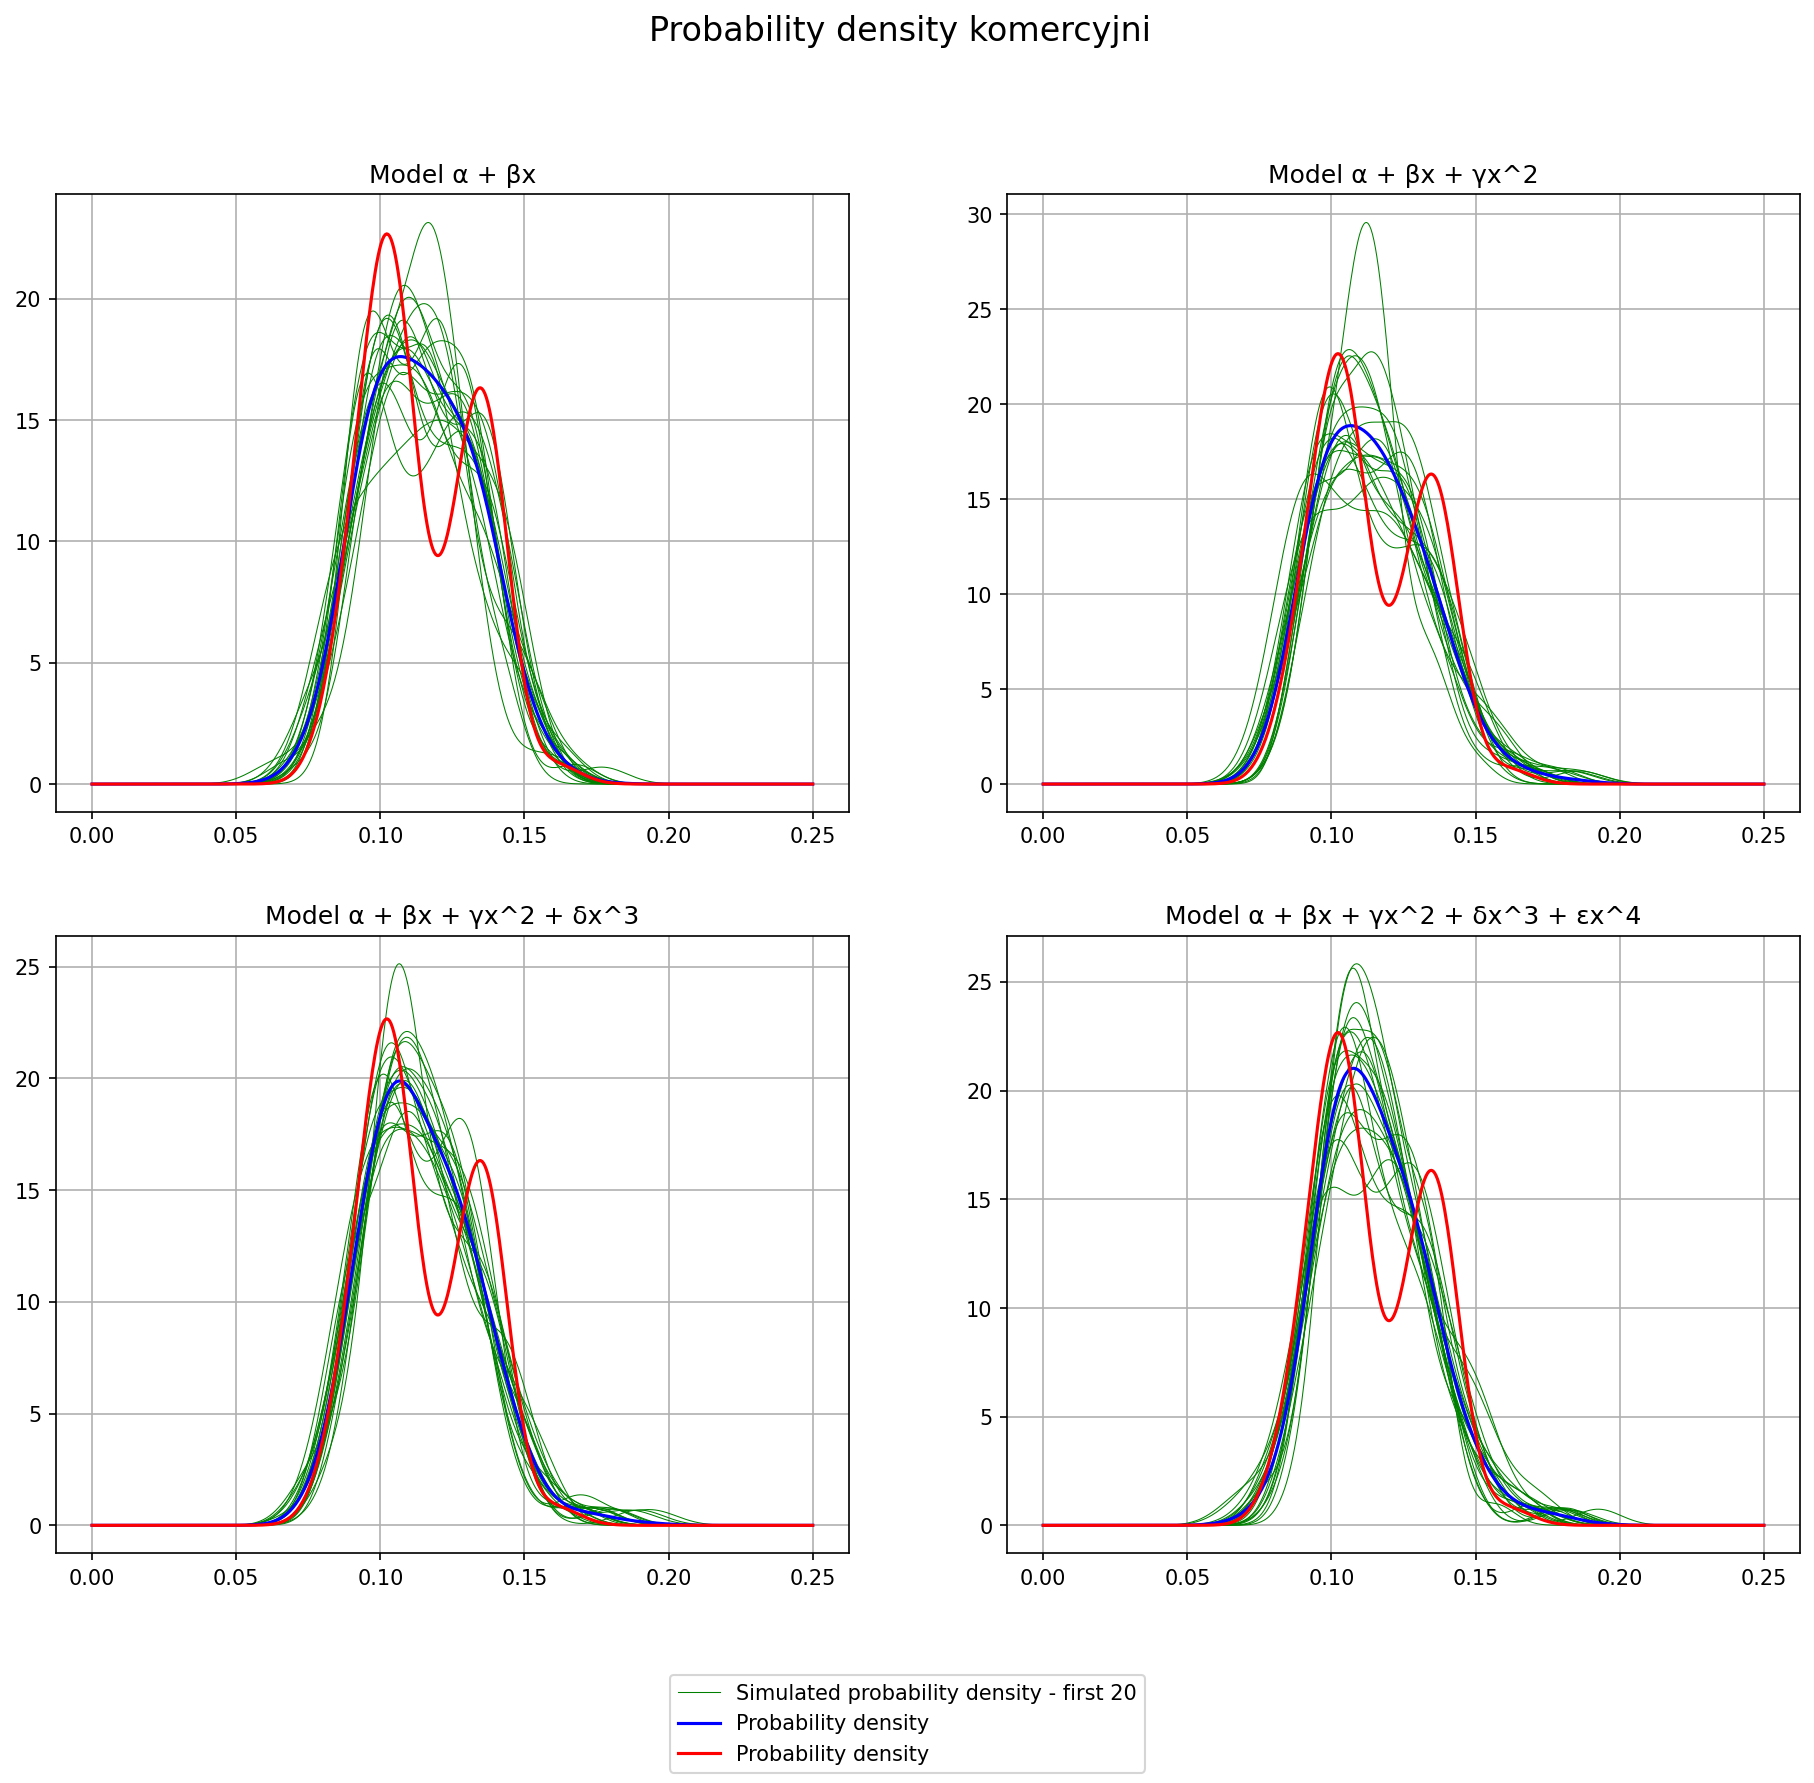

In [90]:
f, axs = plt.subplots(2, 2, figsize=(15,12), dpi=150)

(i_density1, i_sim_density1, ui1) = PlotProbabilityDensity(ei_mean_list, i_fit_degree1, 1, axs[0, 0], densityNum=20, linEnd=0.25)
(i_density2, i_sim_density2, ui2) = PlotProbabilityDensity(ei_mean_list, i_fit_degree2, 2, axs[0, 1], densityNum=20, linEnd=0.25)
(i_density3, i_sim_density3, ui3) = PlotProbabilityDensity(ei_mean_list, i_fit_degree3, 3, axs[1, 0], densityNum=20, linEnd=0.25)
(i_density4, i_sim_density4, ui4) = PlotProbabilityDensity(ei_mean_list, i_fit_degree4, 4, axs[1, 1], densityNum=20, linEnd=0.25)

f.suptitle('Probability density komercyjni', fontsize=16)
plt.rcParams['axes.grid'] = True
handles, labels = axs[0, 0].get_legend_handles_labels()
f.legend(handles, labels, loc='lower center')
plt.savefig('Probability density komercyjni.png', dpi=300, facecolor='w')
plt.show()

Total difference: 482.32213821685855
Total difference: 501.5853502463847
Total difference: 496.4551539933094
Total difference: 578.8071592513314


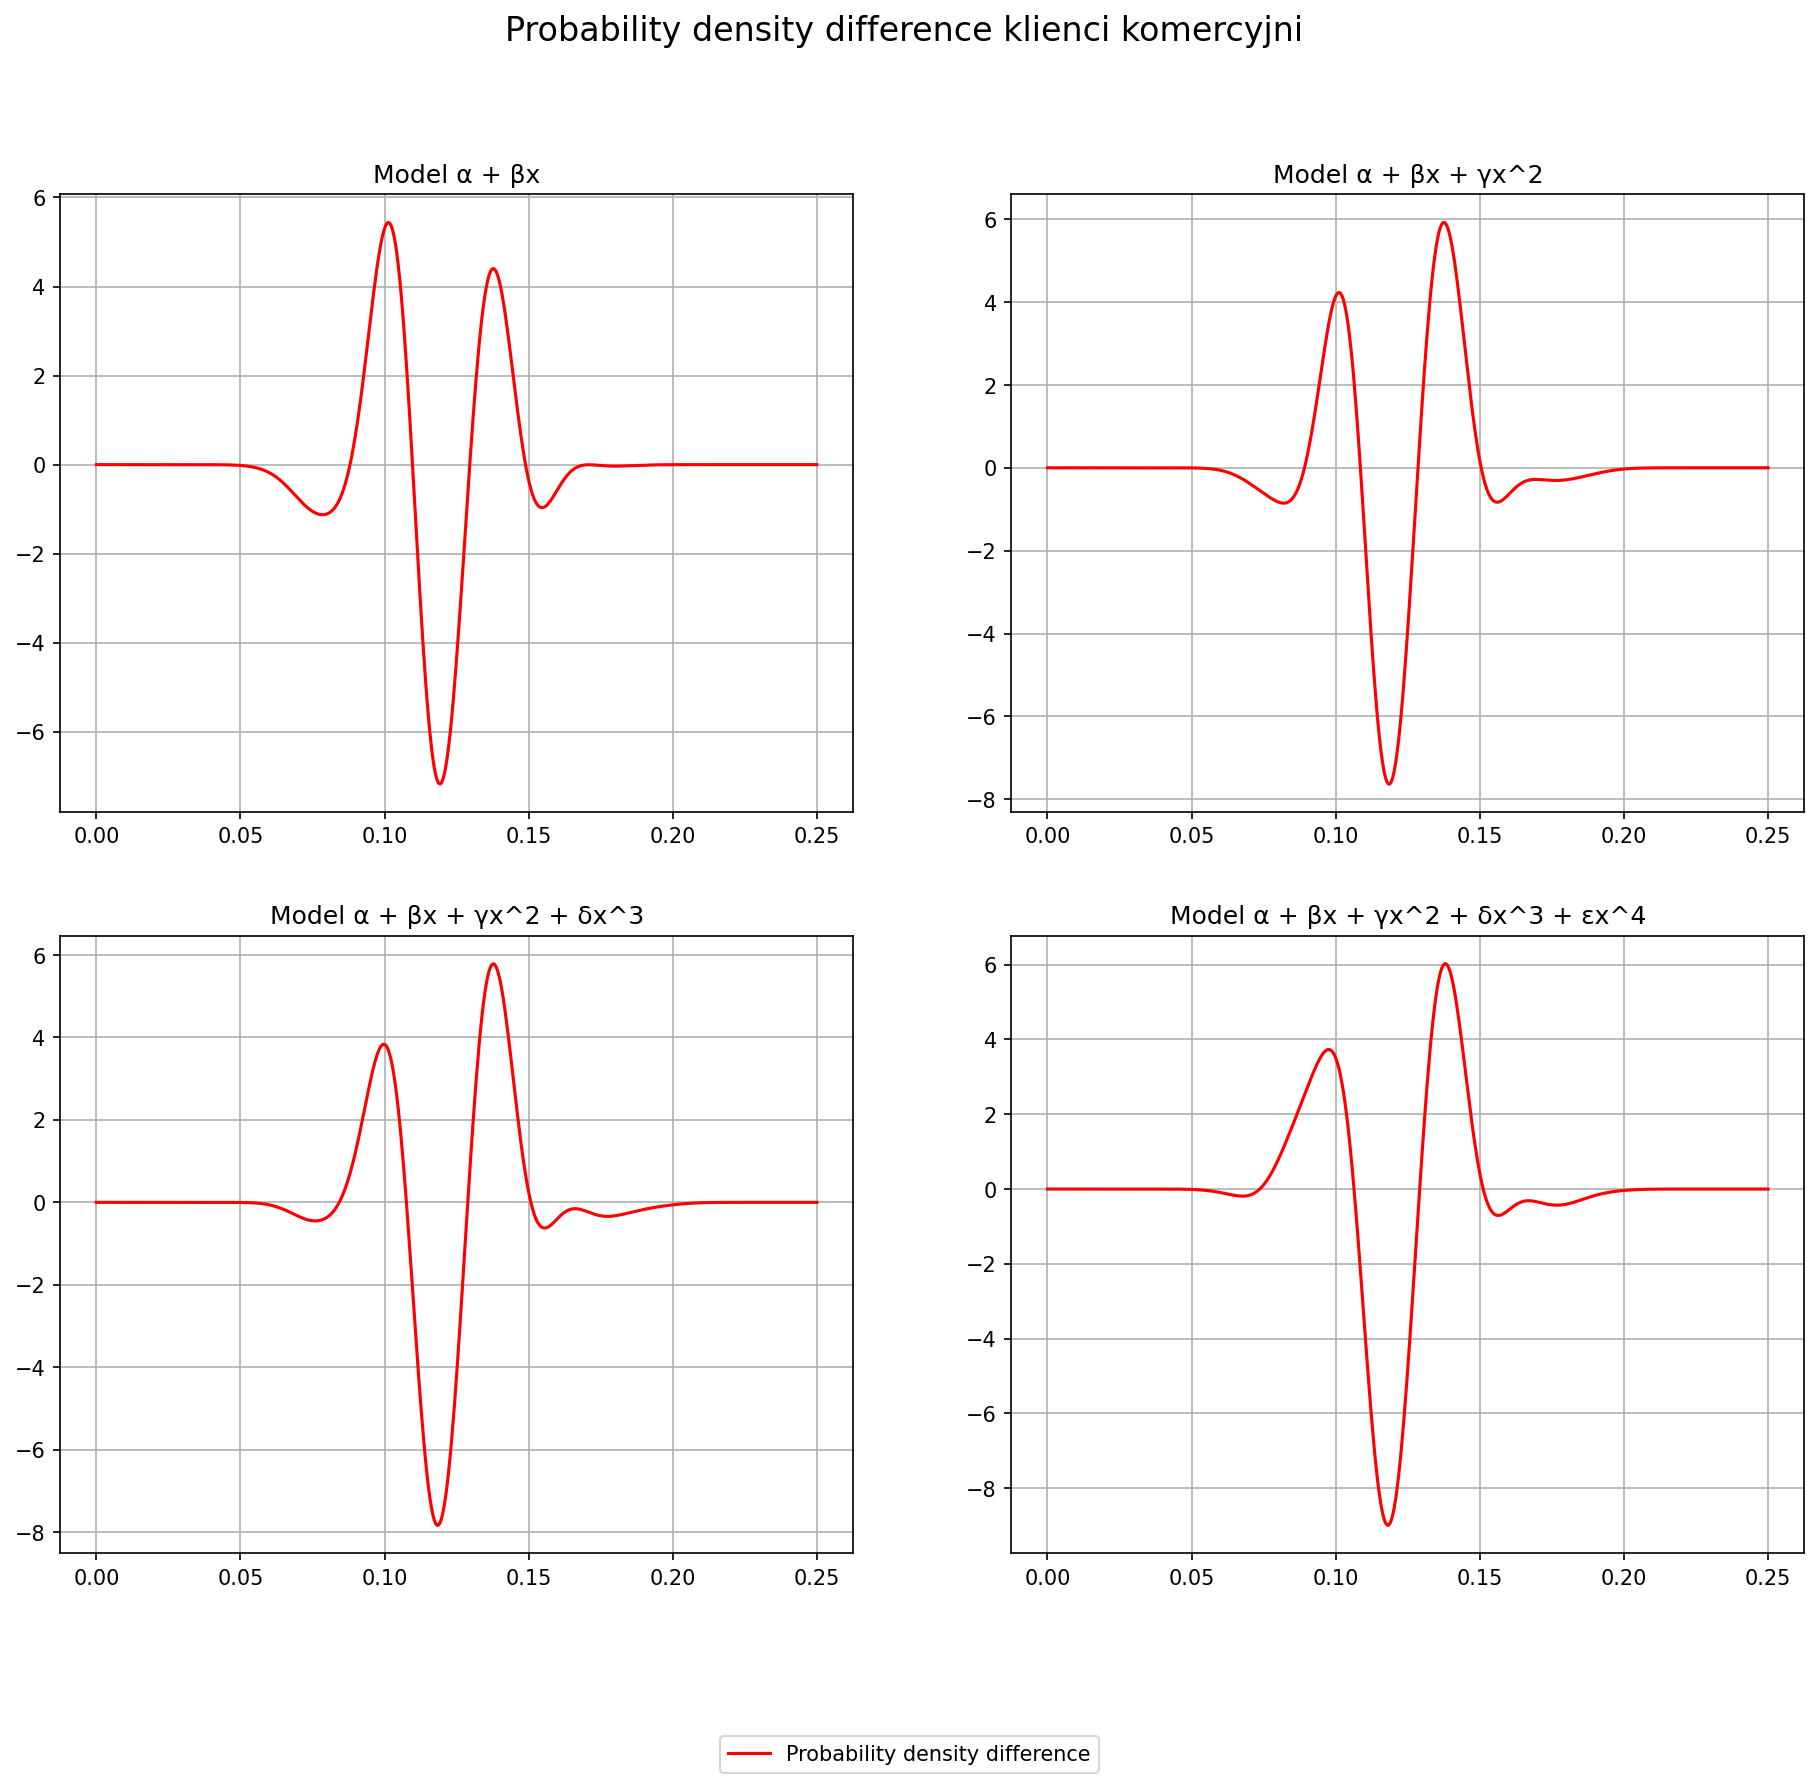

In [91]:
f, axs = plt.subplots(2, 2, figsize=(15,12), dpi=150)

PlotDensityDifference(i_density1, i_sim_density1, ui1, 1, axs[0, 0])
PlotDensityDifference(i_density2, i_sim_density2, ui2, 2, axs[0, 1])
PlotDensityDifference(i_density3, i_sim_density3, ui3, 3, axs[1, 0])
PlotDensityDifference(i_density4, i_sim_density4, ui4, 4, axs[1, 1])

f.suptitle('Probability density difference klienci komercyjni', fontsize=16)
plt.rcParams['axes.grid'] = True
handles, labels = axs[0, 0].get_legend_handles_labels()
f.legend(handles, labels, loc='lower center')
plt.savefig('Probability density difference klienci komercyjni.png', dpi=300, facecolor='w')
plt.show()

# Notatki

### Prior dla modeli stan
Prior dla wartości zmiennych wielomianu real<lower=0> wziął się z tąd że zależność nie może być ujemna(cena prądu nie może maleć przy wzroście ceny paliwa).


Prior dla beta normal(0.007,0.01) wzią się z:


    Dla elektrowni gazowych η ∈ (45%, 57%) => η ~= (45% + 57%) / 2 = 51%  https://www.sciencedirect.com/topics/engineering/natural-gas-combined-cycle
    1MJ ~= 277.78 KWh
    1 / (0.51 * 277.78) = 0.007058 ~= 0.007
    Natomiast odchylenie 0.01 jest większe o rząd wielkości ponieważ gaz stanowi tylko ~25% energii w EU. https://ec.europa.eu/eurostat/statistics-explained/index.php?title=Energy_statistics_-_an_overview

Prior dla pozostałych wartości wielomianu jest równy normal(0,0.001) ponieważ kolejne stopnie nie mogą być ważniejsze od pierwszego ze względu na zestawiane wartości